In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples, silhouette_score
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
import scipy.stats as ss
import copy
from numpy.random import seed
from scipy.stats import shapiro
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',2500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Using TensorFlow backend.


### read files

#### campaign desc

In [2]:
camp_desc = pd.read_csv('campaign_desc.csv')

In [3]:
camp_desc.head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [4]:
len(camp_desc)

30

#### campaign table

In [5]:
camp_table = pd.read_csv('campaign_table.csv')

In [6]:
camp_table.head()

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


In [7]:
len(camp_table)

7208

#### causal data

In [8]:
causal = pd.read_csv('causal_data.csv')

In [9]:
causal.head()

,PRODUCT_ID,STORE_ID,WEEK_NO,display,mailer
0,26190,286,70,0,A
1,26190,288,70,0,A
2,26190,289,70,0,A
3,26190,292,70,0,A
4,26190,293,70,0,A


In [10]:
len(causal)

36786524

#### coupon

In [11]:
coupon = pd.read_csv('coupon.csv')

In [12]:
coupon.head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


In [13]:
len(coupon)

124548

#### coupon redempt

In [14]:
coupon_redmpt = pd.read_csv('coupon_redempt.csv')

In [15]:
coupon_redmpt.head()

,household_key,DAY,COUPON_UPC,CAMPAIGN
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18


#### hh_demographic

In [16]:
hh_demog = pd.read_csv('hh_demographic.csv')

In [17]:
hh_demog.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [18]:
len(hh_demog)

801

#### product

In [19]:
product = pd.read_csv('product.csv')

In [20]:
product.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [21]:
len(product)

92353

#### transaction_data

In [22]:
transaction_data = pd.read_csv('transaction_data.csv')

In [23]:
transaction_data.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39000,364,-0.60000,1631,1,0.00000,0.00000
1,2375,26984851472,1,1033142,1,0.82000,364,0.00000,1631,1,0.00000,0.00000
2,2375,26984851472,1,1036325,1,0.99000,364,-0.30000,1631,1,0.00000,0.00000
3,2375,26984851472,1,1082185,1,1.21000,364,0.00000,1631,1,0.00000,0.00000
4,2375,26984851472,1,8160430,1,1.50000,364,-0.39000,1631,1,0.00000,0.00000


In [24]:
len(transaction_data)

2595732

#### comment : reading files finished 

### ***

## I will start from transaction data

### lets find unique households in transaction data

In [25]:
transaction_data['household_key'].nunique()

2500

### now, lets find if there is a zero quantity rows in our data, if there is , I will discard them

In [26]:
len(transaction_data[transaction_data['QUANTITY'] == 0])

14466

In [27]:
transaction_data2 = transaction_data[transaction_data['QUANTITY']!=0]

### calculate actual prices

In [28]:
transaction_data2['actual_product_price'] = np.where(transaction_data2['RETAIL_DISC']>0,
                                            (transaction_data2['SALES_VALUE'] - (transaction_data2['RETAIL_DISC'] - transaction_data2['COUPON_MATCH_DISC'])) / transaction_data2['QUANTITY'],
                                           np.where(transaction_data2['RETAIL_DISC']==0,
                                            (transaction_data2['SALES_VALUE'] - transaction_data2['COUPON_MATCH_DISC']) / transaction_data2['QUANTITY'],transaction_data2['SALES_VALUE']))

C:\Users\Hincal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [29]:
len(transaction_data2)

2581266

### find how many distinct product we have in our transaction data

In [30]:
transaction_data['PRODUCT_ID'].nunique()

92339

In [31]:
product['PRODUCT_ID'].nunique()

92353

In [32]:
len(transaction_data2[transaction_data2['PRODUCT_ID'].isin (product['PRODUCT_ID'])==True])

2581266

#### comment : it is good, we can merge transaction data with product data

### So lets merge !

In [33]:
transaction_data3 = pd.merge(transaction_data2,product,on='PRODUCT_ID',how='inner')

In [34]:
len(transaction_data3)

2581266

In [35]:
transaction_data3.isnull().sum()

household_key           0
BASKET_ID               0
DAY                     0
PRODUCT_ID              0
QUANTITY                0
SALES_VALUE             0
STORE_ID                0
RETAIL_DISC             0
TRANS_TIME              0
WEEK_NO                 0
COUPON_DISC             0
COUPON_MATCH_DISC       0
actual_product_price    0
MANUFACTURER            0
DEPARTMENT              0
BRAND                   0
COMMODITY_DESC          0
SUB_COMMODITY_DESC      0
CURR_SIZE_OF_PRODUCT    0
dtype: int64

In [36]:
transaction_data3.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,actual_product_price,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,2375,26984851472,1,1004906,1,1.39000,364,-0.60000,1631,1,0.00000,0.00000,1.39000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB
1,1929,27021022215,4,1004906,1,1.39000,441,-0.60000,1755,1,0.00000,0.00000,1.39000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB
2,568,27021090189,4,1004906,1,1.39000,446,-0.60000,35,1,0.00000,0.00000,1.39000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB
3,887,27031467254,5,1004906,1,1.39000,298,-0.60000,1551,1,0.00000,0.00000,1.39000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB
4,175,27057508267,7,1004906,1,1.99000,446,0.00000,2303,2,0.00000,0.00000,1.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB


### now I will merge transaction data with causal data

In [37]:
transaction_data4 = pd.merge(transaction_data3,causal,how='left',on=['PRODUCT_ID','STORE_ID','WEEK_NO'])

In [38]:
len(transaction_data4)

2582122

In [39]:
transaction_data4.isnull().sum()

household_key                 0
BASKET_ID                     0
DAY                           0
PRODUCT_ID                    0
QUANTITY                      0
SALES_VALUE                   0
STORE_ID                      0
RETAIL_DISC                   0
TRANS_TIME                    0
WEEK_NO                       0
COUPON_DISC                   0
COUPON_MATCH_DISC             0
actual_product_price          0
MANUFACTURER                  0
DEPARTMENT                    0
BRAND                         0
COMMODITY_DESC                0
SUB_COMMODITY_DESC            0
CURR_SIZE_OF_PRODUCT          0
display                 2018356
mailer                  2018356
dtype: int64

#### I will merge camp and camp desc tables now

In [40]:
camp_merged = pd.merge(camp_table,camp_desc,how='left',on=['CAMPAIGN','DESCRIPTION'])

In [41]:
len(camp_merged)

7208

In [42]:
camp_merged.head()

,DESCRIPTION,household_key,CAMPAIGN,START_DAY,END_DAY
0,TypeA,17,26,224,264
1,TypeA,27,26,224,264
2,TypeA,212,26,224,264
3,TypeA,208,26,224,264
4,TypeA,192,26,224,264


In [43]:
camp_merged.isnull().sum()

DESCRIPTION      0
household_key    0
CAMPAIGN         0
START_DAY        0
END_DAY          0
dtype: int64

### Now I will join transaction data with camp data

In [44]:
transaction_data4 = transaction_data4.set_index('household_key')
camp_merged = camp_merged.set_index('household_key')
transaction_data5 = pd.merge(transaction_data4,camp_merged,how='left',on='household_key',left_index=True,right_index=True)

In [45]:
transaction_data5.reset_index(inplace=True)

In [46]:
len(transaction_data4)

2582122

In [47]:
transaction_data5.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,actual_product_price,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,display,mailer,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,1,28744672720,137,1004906,1,1.79000,436,0.00000,2003,20,0.00000,0.00000,1.79000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264
1,1,29672186253,192,1004906,1,2.49000,436,0.00000,1422,28,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264
2,1,31624896613,311,1004906,1,2.99000,436,0.00000,1630,45,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264
3,1,31818756113,324,1004906,1,2.99000,436,0.00000,1426,47,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264
4,1,32259826179,361,1004906,1,2.49000,436,0.00000,1329,52,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264


In [48]:
transaction_data5.isnull().sum()

household_key                 0
BASKET_ID                     0
DAY                           0
PRODUCT_ID                    0
QUANTITY                      0
SALES_VALUE                   0
STORE_ID                      0
RETAIL_DISC                   0
TRANS_TIME                    0
WEEK_NO                       0
COUPON_DISC                   0
COUPON_MATCH_DISC             0
actual_product_price          0
MANUFACTURER                  0
DEPARTMENT                    0
BRAND                         0
COMMODITY_DESC                0
SUB_COMMODITY_DESC            0
CURR_SIZE_OF_PRODUCT          0
display                 2018356
mailer                  2018356
DESCRIPTION                   0
CAMPAIGN                      0
START_DAY                     0
END_DAY                       0
dtype: int64

### mark if transaction day is between campaign dates

In [49]:
transaction_data5['is_between_camp_dates'] = np.where((transaction_data5['DAY']>=transaction_data5['START_DAY']) & (transaction_data5['DAY']<=transaction_data5['END_DAY']),1,0)

In [50]:
transaction_data5.head(10)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,actual_product_price,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,display,mailer,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY,is_between_camp_dates
0,1,28744672720,137,1004906,1,1.79000,436,0.00000,2003,20,0.00000,0.00000,1.79000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
1,1,29672186253,192,1004906,1,2.49000,436,0.00000,1422,28,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
2,1,31624896613,311,1004906,1,2.99000,436,0.00000,1630,45,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
3,1,31818756113,324,1004906,1,2.99000,436,0.00000,1426,47,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
4,1,32259826179,361,1004906,1,2.49000,436,0.00000,1329,52,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
5,1,33409625841,436,1004906,1,2.99000,436,0.00000,1227,63,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,0,F,TypeA,26,224,264,0
6,1,36027807102,540,1004906,1,2.00000,436,-0.29000,1851,78,0.00000,0.00000,2.00000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,0,F,TypeA,26,224,264,0
7,1,40666800522,597,1004906,1,2.99000,436,0.00000,1125,86,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
8,1,41338185846,639,1004906,1,2.49000,436,0.00000,1230,92,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
9,1,41809641616,675,1004906,1,2.49000,436,0.00000,1640,97,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0


In [51]:
transaction_data5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2582122 entries, 0 to 2582121
Data columns (total 26 columns):
household_key            int64
BASKET_ID                int64
DAY                      int64
PRODUCT_ID               int64
QUANTITY                 int64
SALES_VALUE              float64
STORE_ID                 int64
RETAIL_DISC              float64
TRANS_TIME               int64
WEEK_NO                  int64
COUPON_DISC              float64
COUPON_MATCH_DISC        float64
actual_product_price     float64
MANUFACTURER             int64
DEPARTMENT               object
BRAND                    object
COMMODITY_DESC           object
SUB_COMMODITY_DESC       object
CURR_SIZE_OF_PRODUCT     object
display                  object
mailer                   object
DESCRIPTION              object
CAMPAIGN                 int64
START_DAY                int64
END_DAY                  int64
is_between_camp_dates    int32
dtypes: float64(5), int32(1), int64(12), object(8)
memory usage

#### data gathering is completed

### **

In [52]:
### for the memory issues
transaction_data2 = None
transaction_data3 = None
transaction_data4 = None

### Now I will find each household's daily-weekly aggregated buying information

In [53]:
transaction_data5.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,actual_product_price,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,display,mailer,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY,is_between_camp_dates
0,1,28744672720,137,1004906,1,1.79000,436,0.00000,2003,20,0.00000,0.00000,1.79000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
1,1,29672186253,192,1004906,1,2.49000,436,0.00000,1422,28,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
2,1,31624896613,311,1004906,1,2.99000,436,0.00000,1630,45,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
3,1,31818756113,324,1004906,1,2.99000,436,0.00000,1426,47,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
4,1,32259826179,361,1004906,1,2.49000,436,0.00000,1329,52,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0


In [54]:
transaction_data5.columns.tolist()

['household_key',
 'BASKET_ID',
 'DAY',
 'PRODUCT_ID',
 'QUANTITY',
 'SALES_VALUE',
 'STORE_ID',
 'RETAIL_DISC',
 'TRANS_TIME',
 'WEEK_NO',
 'COUPON_DISC',
 'COUPON_MATCH_DISC',
 'actual_product_price',
 'MANUFACTURER',
 'DEPARTMENT',
 'BRAND',
 'COMMODITY_DESC',
 'SUB_COMMODITY_DESC',
 'CURR_SIZE_OF_PRODUCT',
 'display',
 'mailer',
 'DESCRIPTION',
 'CAMPAIGN',
 'START_DAY',
 'END_DAY',
 'is_between_camp_dates']

In [55]:
transaction_data5.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,actual_product_price,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,display,mailer,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY,is_between_camp_dates
0,1,28744672720,137,1004906,1,1.79000,436,0.00000,2003,20,0.00000,0.00000,1.79000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
1,1,29672186253,192,1004906,1,2.49000,436,0.00000,1422,28,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
2,1,31624896613,311,1004906,1,2.99000,436,0.00000,1630,45,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
3,1,31818756113,324,1004906,1,2.99000,436,0.00000,1426,47,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
4,1,32259826179,361,1004906,1,2.49000,436,0.00000,1329,52,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0


In [56]:
transaction_data5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2582122 entries, 0 to 2582121
Data columns (total 26 columns):
household_key            int64
BASKET_ID                int64
DAY                      int64
PRODUCT_ID               int64
QUANTITY                 int64
SALES_VALUE              float64
STORE_ID                 int64
RETAIL_DISC              float64
TRANS_TIME               int64
WEEK_NO                  int64
COUPON_DISC              float64
COUPON_MATCH_DISC        float64
actual_product_price     float64
MANUFACTURER             int64
DEPARTMENT               object
BRAND                    object
COMMODITY_DESC           object
SUB_COMMODITY_DESC       object
CURR_SIZE_OF_PRODUCT     object
display                  object
mailer                   object
DESCRIPTION              object
CAMPAIGN                 int64
START_DAY                int64
END_DAY                  int64
is_between_camp_dates    int32
dtypes: float64(5), int32(1), int64(12), object(8)
memory usage

### get each customers' variales average or count values in daily and weekly basis by aggregation

In [57]:
transaction_data5['display'] = np.where(transaction_data5['display'].isin(['NaN','0']),0,0)
transaction_data5['mailer'] = np.where(transaction_data5['display'].isin(['NaN','0']),0,0)

C:\Users\Hincal\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [58]:
agg1 = transaction_data5.groupby(['household_key','DAY','WEEK_NO']).agg({
                                                       'BASKET_ID' : 'count',
                                                       'PRODUCT_ID': 'count',
                                                       'QUANTITY': 'mean',
                                                       'SALES_VALUE':'mean',
                                                       'STORE_ID' : 'nunique',
                                                       'RETAIL_DISC' : 'mean',
                                                       'TRANS_TIME': 'mean',
                                                       'actual_product_price' : 'mean',
                                                       'COUPON_DISC': 'mean',
                                                       'COUPON_MATCH_DISC': 'mean',
                                                       'DEPARTMENT' : lambda x: pd.Series.value_counts(x).index[0],
                                                       'BRAND' : lambda x: pd.Series.mode(x)[0],
                                                       'COMMODITY_DESC' : lambda x: pd.Series.mode(x)[0],
                                                       'DESCRIPTION' : lambda x: pd.Series.mode(x)[0],
                                                       'display' : 'sum',
                                                       'mailer' : 'sum',
                                                       'is_between_camp_dates' : 'sum'
                                                       
    
})

#agg1.columns = agg1.columns.droplevel(0)

agg1.columns = ['basket_cnt',
                'product_cnt',
                'avg_quantity',
                'avg_sales',
                'store_cnt',
                'retail_disc_mean',
                'avg_trans_time',
                'avg_actual_prod_price',
                'avg_coupon_disc',
                'avg_coup_mdisc',
                'most_freq_depart',
                'most_freq_brand',
                'most_freq_commodity',
                'most_freq_camp',
                'most_freq_display',
                'most_freq_mailer',
                'camp_date_exp'
               ]

agg1.reset_index(inplace=True)

agg1.head()

,household_key,DAY,WEEK_NO,basket_cnt,product_cnt,avg_quantity,avg_sales,store_cnt,retail_disc_mean,avg_trans_time,avg_actual_prod_price,avg_coupon_disc,avg_coup_mdisc,most_freq_depart,most_freq_brand,most_freq_commodity,most_freq_camp,most_freq_display,most_freq_mailer,camp_date_exp
0,1,51,8,30,30,1.13333,2.62200,1,-0.55133,1456.00000,2.58567,-0.03333,0.00000,GROCERY,National,FRUIT - SHELF STABLE,TypeA,0,0,0
1,1,67,10,11,11,1.27273,3.73636,1,-0.78091,2002.00000,3.49636,0.00000,0.00000,GROCERY,National,CANDY - PACKAGED,TypeA,0,0,0
2,1,88,13,12,12,1.08333,2.24167,1,-0.56000,1604.00000,2.24167,0.00000,0.00000,GROCERY,National,BAG SNACKS,TypeA,0,0,0
3,1,94,14,22,22,1.45455,2.88318,1,-0.50364,1937.00000,2.72045,-0.02273,-0.02273,GROCERY,National,DELI MEATS,TypeA,0,0,0
4,1,101,15,17,17,1.17647,3.14412,1,-0.96588,1603.00000,3.14412,0.00000,0.00000,GROCERY,National,BAKED BREAD/BUNS/ROLLS,TypeA,0,0,0


In [59]:
len(agg1)

225344

In [60]:
agg1.isnull().sum()

household_key            0
DAY                      0
WEEK_NO                  0
basket_cnt               0
product_cnt              0
avg_quantity             0
avg_sales                0
store_cnt                0
retail_disc_mean         0
avg_trans_time           0
avg_actual_prod_price    0
avg_coupon_disc          0
avg_coup_mdisc           0
most_freq_depart         0
most_freq_brand          0
most_freq_commodity      0
most_freq_camp           0
most_freq_display        0
most_freq_mailer         0
camp_date_exp            0
dtype: int64

In [61]:
agg2 = copy.deepcopy(agg1)

### lets describe data

In [62]:
agg1.describe()

,household_key,DAY,WEEK_NO,basket_cnt,product_cnt,avg_quantity,avg_sales,store_cnt,retail_disc_mean,avg_trans_time,avg_actual_prod_price,avg_coupon_disc,avg_coup_mdisc,most_freq_display,most_freq_mailer,camp_date_exp
count,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000
mean,1246.87376,385.66003,55.79554,11.45858,11.45858,680.64124,4.69563,1.03569,-0.56678,1552.04351,4.48074,-0.01036,-0.00171,0.00000,0.00000,0.82165
std,719.37603,189.30351,27.04310,13.47972,13.47972,2845.48936,6.98427,0.19096,0.99889,415.79670,6.88737,0.10653,0.01625,0.00000,0.00000,4.64473
min,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000,1.00000,-87.60000,0.00000,0.00000,-14.99500,-1.93333,0.00000,0.00000,0.00000
25%,636.00000,223.00000,33.00000,3.00000,3.00000,1.00000,2.06333,1.00000,-0.69333,1259.00000,1.97222,0.00000,0.00000,0.00000,0.00000,0.00000
50%,1245.00000,389.00000,56.00000,7.00000,7.00000,1.20000,2.82000,1.00000,-0.39468,1612.00000,2.65667,0.00000,0.00000,0.00000,0.00000,0.00000
75%,1865.00000,549.00000,79.00000,15.00000,15.00000,1.50000,4.04385,1.00000,-0.16770,1846.00000,3.79000,0.00000,0.00000,0.00000,0.00000,0.00000
max,2500.00000,711.00000,102.00000,184.00000,184.00000,85055.00000,299.99000,6.00000,0.00000,2359.00000,299.99000,0.00000,0.00000,0.00000,0.00000,147.00000


#### comment : in some variables , there are high variance, so handling these values as outlier and changing them with mean values may reduce variance

### now go step by step

### 1- ) define the churn using customer's max week appearence

In [63]:
grouped_df = agg2.groupby('household_key')['WEEK_NO'].max().reset_index().rename(columns={'WEEK_NO':'MAX_WEEK'})
grouped_df.head()

,household_key,MAX_WEEK
0,1,102
1,2,96
2,3,101
3,4,90
4,5,101


In [64]:
len(grouped_df)

2500

In [65]:
grouped_df.reset_index(inplace=True)

### merge it with main frame

In [66]:
agg3 = pd.merge(agg2,grouped_df,how='inner',on='household_key')

### get also data's whole max week

In [67]:
agg3['MAX_DATA_WEEK'] = agg3['WEEK_NO'].max()

In [68]:
len(agg3)

225344

In [69]:
agg3['CohortIndex'] = agg3['MAX_WEEK'] - agg3['WEEK_NO']

In [70]:
agg3.describe()

,household_key,DAY,WEEK_NO,basket_cnt,product_cnt,avg_quantity,avg_sales,store_cnt,retail_disc_mean,avg_trans_time,avg_actual_prod_price,avg_coupon_disc,avg_coup_mdisc,most_freq_display,most_freq_mailer,camp_date_exp,index,MAX_WEEK,MAX_DATA_WEEK,CohortIndex
count,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000
mean,1246.87376,385.66003,55.79554,11.45858,11.45858,680.64124,4.69563,1.03569,-0.56678,1552.04351,4.48074,-0.01036,-0.00171,0.00000,0.00000,0.82165,1245.87376,100.70178,102.00000,44.90624
std,719.37603,189.30351,27.04310,13.47972,13.47972,2845.48936,6.98427,0.19096,0.99889,415.79670,6.88737,0.10653,0.01625,0.00000,0.00000,4.64473,719.37603,3.99541,0.00000,26.86371
min,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000,1.00000,-87.60000,0.00000,0.00000,-14.99500,-1.93333,0.00000,0.00000,0.00000,0.00000,8.00000,102.00000,0.00000
25%,636.00000,223.00000,33.00000,3.00000,3.00000,1.00000,2.06333,1.00000,-0.69333,1259.00000,1.97222,0.00000,0.00000,0.00000,0.00000,0.00000,635.00000,101.00000,102.00000,22.00000
50%,1245.00000,389.00000,56.00000,7.00000,7.00000,1.20000,2.82000,1.00000,-0.39468,1612.00000,2.65667,0.00000,0.00000,0.00000,0.00000,0.00000,1244.00000,102.00000,102.00000,44.00000
75%,1865.00000,549.00000,79.00000,15.00000,15.00000,1.50000,4.04385,1.00000,-0.16770,1846.00000,3.79000,0.00000,0.00000,0.00000,0.00000,0.00000,1864.00000,102.00000,102.00000,68.00000
max,2500.00000,711.00000,102.00000,184.00000,184.00000,85055.00000,299.99000,6.00000,0.00000,2359.00000,299.99000,0.00000,0.00000,0.00000,0.00000,147.00000,2499.00000,102.00000,102.00000,101.00000


#### from knowledge of segmentation work, We know that our customers come to store biweekly, so using customers' last week or max week  date as a point, if a customer's max_week info is lesser than max data week - 3, we can accept them as churned

### so mark them as "churned"

In [71]:
agg3['is_churned'] = np.where(agg3['MAX_WEEK']<=agg3['MAX_DATA_WEEK']-3,'1','0')

In [72]:
agg3.head()

,household_key,DAY,WEEK_NO,basket_cnt,product_cnt,avg_quantity,avg_sales,store_cnt,retail_disc_mean,avg_trans_time,avg_actual_prod_price,avg_coupon_disc,avg_coup_mdisc,most_freq_depart,most_freq_brand,most_freq_commodity,most_freq_camp,most_freq_display,most_freq_mailer,camp_date_exp,index,MAX_WEEK,MAX_DATA_WEEK,CohortIndex,is_churned
0,1,51,8,30,30,1.13333,2.62200,1,-0.55133,1456.00000,2.58567,-0.03333,0.00000,GROCERY,National,FRUIT - SHELF STABLE,TypeA,0,0,0,0,102,102,94,0
1,1,67,10,11,11,1.27273,3.73636,1,-0.78091,2002.00000,3.49636,0.00000,0.00000,GROCERY,National,CANDY - PACKAGED,TypeA,0,0,0,0,102,102,92,0
2,1,88,13,12,12,1.08333,2.24167,1,-0.56000,1604.00000,2.24167,0.00000,0.00000,GROCERY,National,BAG SNACKS,TypeA,0,0,0,0,102,102,89,0
3,1,94,14,22,22,1.45455,2.88318,1,-0.50364,1937.00000,2.72045,-0.02273,-0.02273,GROCERY,National,DELI MEATS,TypeA,0,0,0,0,102,102,88,0
4,1,101,15,17,17,1.17647,3.14412,1,-0.96588,1603.00000,3.14412,0.00000,0.00000,GROCERY,National,BAKED BREAD/BUNS/ROLLS,TypeA,0,0,0,0,102,102,87,0


In [73]:
agg3.groupby('is_churned')['household_key'].count()

is_churned
0    198746
1     26598
Name: household_key, dtype: int64

In [74]:
26598 / 198746

0.13382910851035995

### 2-) make data cleaning

### check nulls

In [75]:
agg3.isnull().sum()

household_key            0
DAY                      0
WEEK_NO                  0
basket_cnt               0
product_cnt              0
avg_quantity             0
avg_sales                0
store_cnt                0
retail_disc_mean         0
avg_trans_time           0
avg_actual_prod_price    0
avg_coupon_disc          0
avg_coup_mdisc           0
most_freq_depart         0
most_freq_brand          0
most_freq_commodity      0
most_freq_camp           0
most_freq_display        0
most_freq_mailer         0
camp_date_exp            0
index                    0
MAX_WEEK                 0
MAX_DATA_WEEK            0
CohortIndex              0
is_churned               0
dtype: int64

### comment : no null values for now, good

### 3-) define a column list to be used in other steps 

In [76]:
cols = agg3.columns.tolist()[3:]
#cols.remove('MAX_WEEK')
cols.remove('MAX_DATA_WEEK')
cols.remove('CohortIndex')
cols.remove('most_freq_depart')
cols.remove('most_freq_brand')
cols.remove('most_freq_commodity')
cols.remove('most_freq_camp')
cols.remove('most_freq_display')
cols.remove('most_freq_mailer')
cols.remove('index')
#cols.remove('is_churned')
cols

['basket_cnt',
 'product_cnt',
 'avg_quantity',
 'avg_sales',
 'store_cnt',
 'retail_disc_mean',
 'avg_trans_time',
 'avg_actual_prod_price',
 'avg_coupon_disc',
 'avg_coup_mdisc',
 'camp_date_exp',
 'MAX_WEEK',
 'is_churned']

### check variables' distribution if gaussian with Shapiro- Wilk Test

In [77]:
cols_to_check_dist = cols

# seed the random number generator
seed(1)
# normality test
for i in cols_to_check_dist:
    stat, p = shapiro(agg3[i])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
    alpha = 0.05
    if p > alpha:
        print('Sample %s looks Gaussian (fail to reject H0)' %i)
    else:
        print('Sample %s does not look Gaussian (reject H0)' %i)

C:\Users\Hincal\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.729, p=0.000
Sample basket_cnt does not look Gaussian (reject H0)
Statistics=0.729, p=0.000
Sample product_cnt does not look Gaussian (reject H0)
Statistics=0.258, p=0.000
Sample avg_quantity does not look Gaussian (reject H0)
Statistics=0.439, p=0.000
Sample avg_sales does not look Gaussian (reject H0)
Statistics=0.176, p=0.000
Sample store_cnt does not look Gaussian (reject H0)
Statistics=0.369, p=0.000
Sample retail_disc_mean does not look Gaussian (reject H0)
Statistics=0.971, p=0.000
Sample avg_trans_time does not look Gaussian (reject H0)
Statistics=0.427, p=0.000
Sample avg_actual_prod_price does not look Gaussian (reject H0)
Statistics=0.065, p=0.000
Sample avg_coupon_disc does not look Gaussian (reject H0)
Statistics=0.077, p=0.000
Sample avg_coup_mdisc does not look Gaussian (reject H0)
Statistics=0.173, p=0.000
Sample camp_date_exp does not look Gaussian (reject H0)
Statistics=0.343, p=0.000
Sample MAX_WEEK does not look Gaussian (reject H0)
Statistics=0.376, p=

### 4-) Check distribution of variables

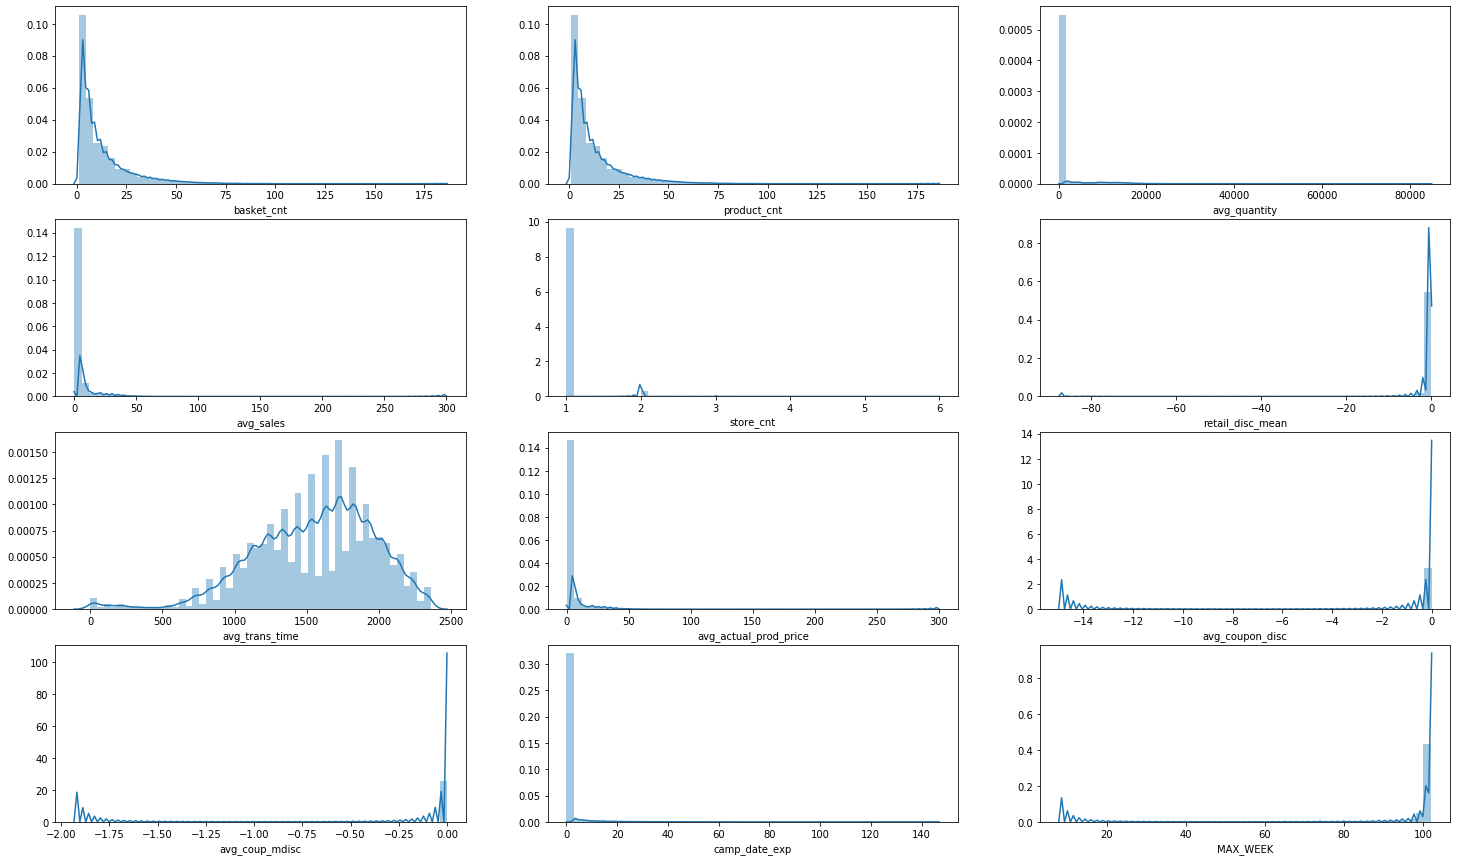

In [78]:
fig, axis = plt.subplots(4,3,figsize=[25,15])
axis = axis.flatten()
for ax, col in zip(axis, cols):
    g = sns.distplot(agg3[col],ax=ax)
    g.set_xlabel(col)

#### comment : 
#### 1-) there are right skewed variables like basket_cnt, product_cnt, avg_sales so with logarithmic transformation they may be handled as normally distributted
#### 2-) there are variables have no specific distribition like avg_coupon_disc and transaction, they can be handled as two seperate class

### 5-) check pairwise distributions

C:\Users\Hincal\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Hincal\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


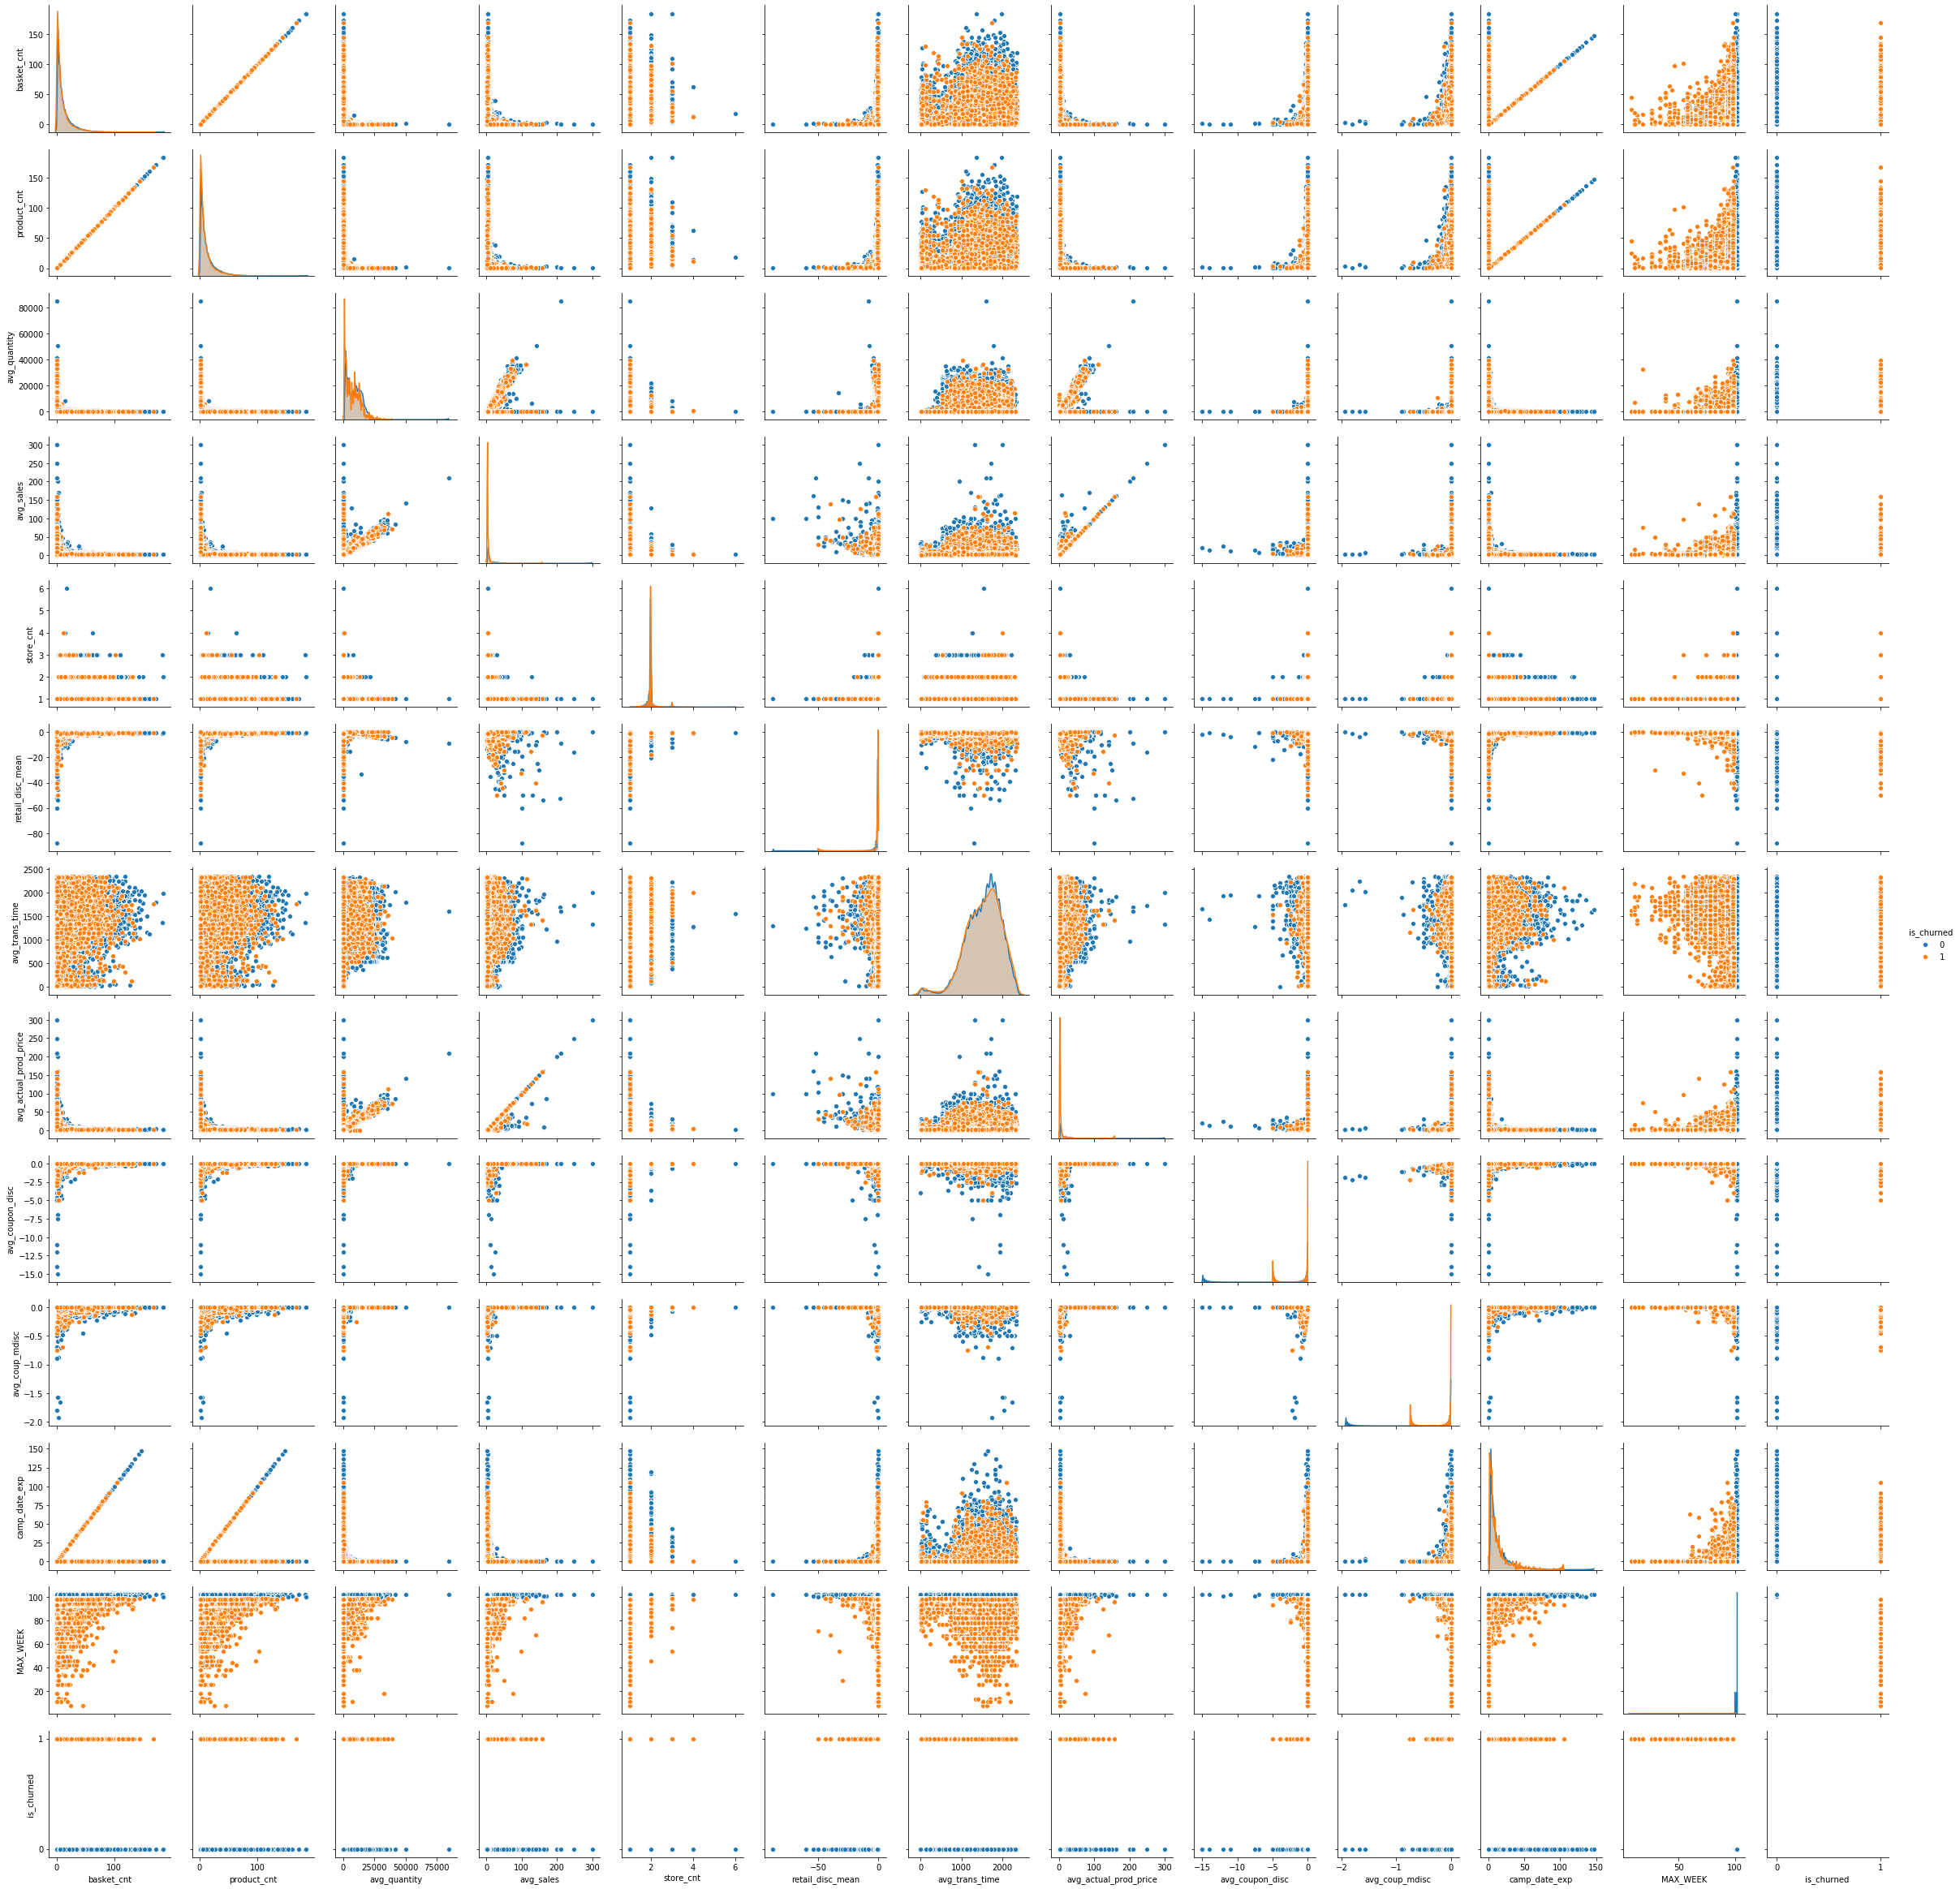

In [79]:
sns.pairplot(agg3[cols], hue="is_churned", height=2.5);

#### comment : generally in some variables there are patterns due to target churn variable

### 6-) check outlier counts

In [80]:
cols.remove('is_churned')
Q1 = agg3[cols].quantile(0.25)
Q3 = agg3[cols].quantile(0.75)
IQR = Q3 - Q1

columns_desc= copy.deepcopy(cols)

desc_df = pd.DataFrame()
for col in columns_desc:
    desc_df[col] = agg3[col].describe(include='all')
    desc_df[col + '_valcounts'] = np.nan
    
try:
    for col in columns_desc:
        desc_df = desc_df.T
        desc_df.columns = ['count','mean','std','min','q25','q50','q75','max']
        desc_df = desc_df.T
        desc_df.loc['min',col + '_valcounts'] = agg3.loc[(agg3[col].values == desc_df.loc['min',col])].count()['household_key']
        desc_df.loc['q25',col + '_valcounts'] = agg3.loc[(agg3[col].values >= desc_df.loc['min',col]) & (agg3[col].values < desc_df.loc['q25',col])].count()['household_key']
        desc_df.loc['q50',col + '_valcounts'] = agg3.loc[(agg3[col].values >= desc_df.loc['q25',col]) & (agg3[col].values < desc_df.loc['q50',col])].count()['household_key']
        desc_df.loc['q75',col + '_valcounts'] = agg3.loc[(agg3[col].values >= desc_df.loc['q50',col]) & (agg3[col].values < desc_df.loc['q75',col])].count()['household_key']
        desc_df.loc['max',col + '_valcounts'] = agg3.loc[(agg3[col].values >= desc_df.loc['q75',col]) & (agg3[col].values < desc_df.loc['max',col])].count()['household_key']
        desc_df.loc['std',col + '_valcounts'] = agg3.loc[(agg3[col].values >= (Q1[col] -  1*IQR[col])) & (agg3[col].values <= (Q3[col] +  1*IQR[col]))].count()['household_key']
        desc_df.loc['count',col + '_valcounts'] = desc_df.loc['count',col]
        desc_df.loc['mean',col + '_valcounts'] = desc_df.loc['count',col + '_valcounts'] -  desc_df.loc['std',col + '_valcounts']
except KeyError:
    print(col)
    
    
    
desc_df_cols = desc_df.columns.tolist()
end_words = ['_valcounts']
val_count_cols = [col for col in desc_df_cols if any(col.endswith(end) for end in end_words)]

desc_df_cnts = desc_df[val_count_cols]

desc_df_cnts = desc_df_cnts.T

desc_df_cnts.columns = ['all_count','outlier_cnts','non_outlier_cnts','equal_min_cnts','betw_q25_min_cnts','betw_q50_q25_cnts','betw_q75_q50_cnts','betw_max_q75_cnts']
desc_df_cnts = desc_df_cnts.T

desc_df_cnts

,basket_cnt_valcounts,product_cnt_valcounts,avg_quantity_valcounts,avg_sales_valcounts,store_cnt_valcounts,retail_disc_mean_valcounts,avg_trans_time_valcounts,avg_actual_prod_price_valcounts,avg_coupon_disc_valcounts,avg_coup_mdisc_valcounts,camp_date_exp_valcounts,MAX_WEEK_valcounts
all_count,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000,225344.00000
outlier_cnts,24027.00000,24027.00000,31542.00000,29935.00000,7820.00000,20751.00000,5366.00000,30208.00000,13579.00000,8076.00000,16414.00000,26598.00000
non_outlier_cnts,201317.00000,201317.00000,193802.00000,195409.00000,217524.00000,204593.00000,219978.00000,195136.00000,211765.00000,217268.00000,208930.00000,198746.00000
equal_min_cnts,28815.00000,28815.00000,72886.00000,60.00000,217524.00000,1.00000,38.00000,60.00000,1.00000,1.00000,208930.00000,2.00000
betw_q25_min_cnts,51525.00000,51525.00000,0.00000,56319.00000,0.00000,56330.00000,56191.00000,56334.00000,13579.00000,8076.00000,0.00000,40912.00000
betw_q50_q25_cnts,60934.00000,60934.00000,108576.00000,56335.00000,0.00000,56342.00000,56262.00000,56306.00000,0.00000,0.00000,0.00000,33911.00000
betw_q75_q50_cnts,55141.00000,55141.00000,52262.00000,56353.00000,0.00000,56336.00000,56545.00000,56332.00000,0.00000,0.00000,0.00000,0.00000
betw_max_q75_cnts,57743.00000,57743.00000,64505.00000,56335.00000,225343.00000,29269.00000,56319.00000,56370.00000,0.00000,0.00000,225343.00000,0.00000


### 7-) lets fill outliers with mean

In [81]:
mean = {}
for col in columns_desc:
    mean[col] = agg3[col].mean()
    agg3[col][((agg3[col] < (Q1[col] -  1.5*IQR[col])) | (agg3[col] > (Q3[col] +  1.5*IQR[col])))] = np.nan
    agg3[col].fillna(mean[col],inplace=True)

C:\Users\Hincal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 8-) check distributions again

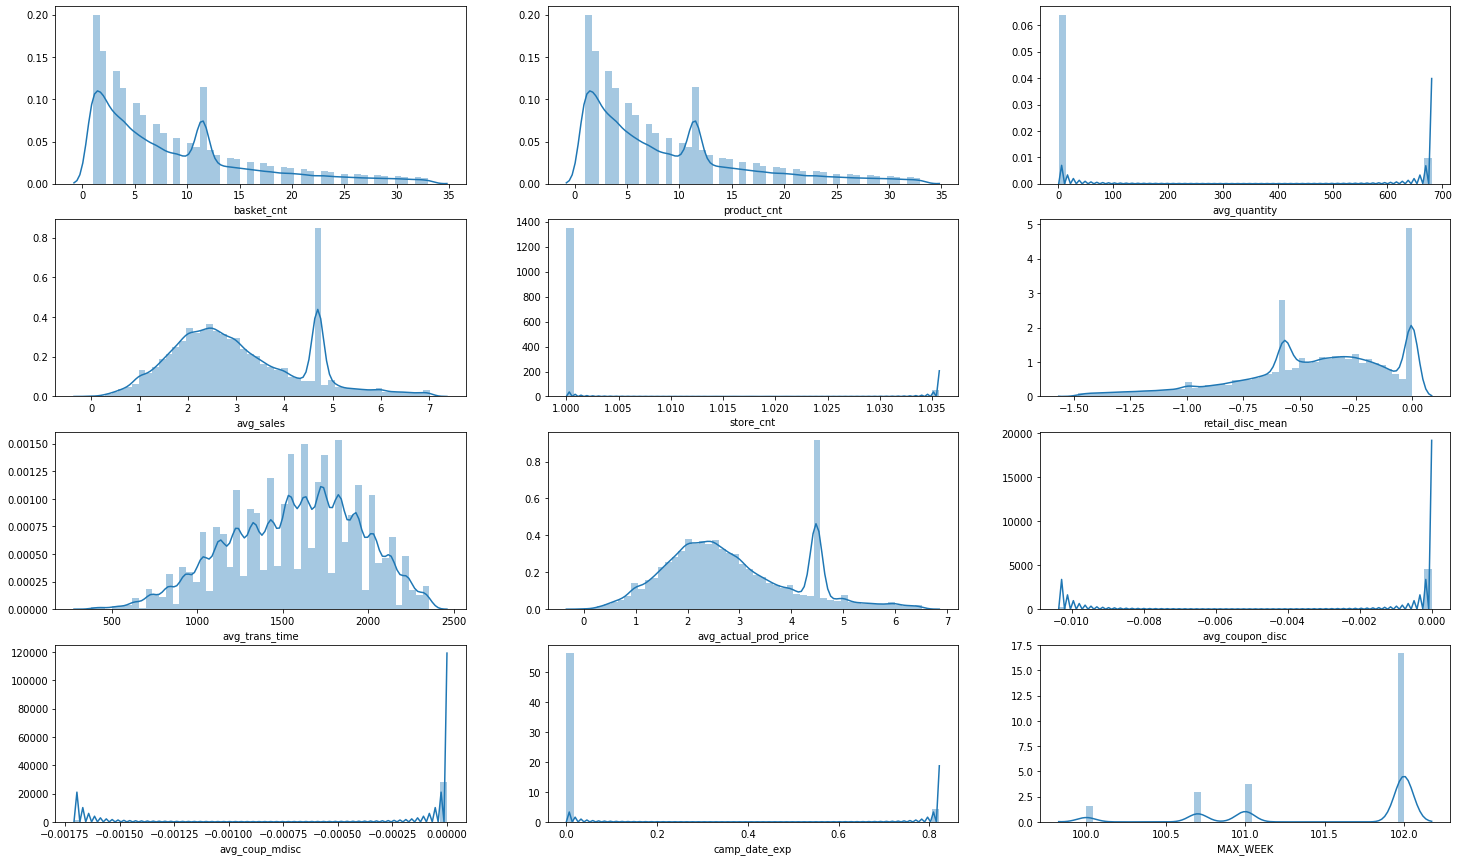

In [82]:
fig, axis = plt.subplots(4,3,figsize=[25,15])
axis = axis.flatten()
for ax, col in zip(axis, columns_desc):
    g = sns.distplot(agg3[col],ax=ax)
    g.set_xlabel(col)

#### comment : especially in right skewed variables, kurtosis decreases by discarding outliers

### get the columns again

In [83]:
feat_select_cols = agg3.columns.tolist()[3:]
feat_select_cols.remove('MAX_WEEK')
feat_select_cols.remove('MAX_DATA_WEEK')
feat_select_cols.remove('CohortIndex')
feat_select_cols.remove('is_churned')
feat_select_cols.remove('most_freq_depart')
feat_select_cols.remove('most_freq_brand')
feat_select_cols.remove('most_freq_commodity')
feat_select_cols.remove('most_freq_camp')
feat_select_cols.remove('most_freq_display')
feat_select_cols.remove('most_freq_mailer')
feat_select_cols.remove('index')
feat_select_cols

['basket_cnt',
 'product_cnt',
 'avg_quantity',
 'avg_sales',
 'store_cnt',
 'retail_disc_mean',
 'avg_trans_time',
 'avg_actual_prod_price',
 'avg_coupon_disc',
 'avg_coup_mdisc',
 'camp_date_exp']

### 9-) check correlation of predictive variables

### data doesnt look gaussian so we should take spearman correlation to check correlations

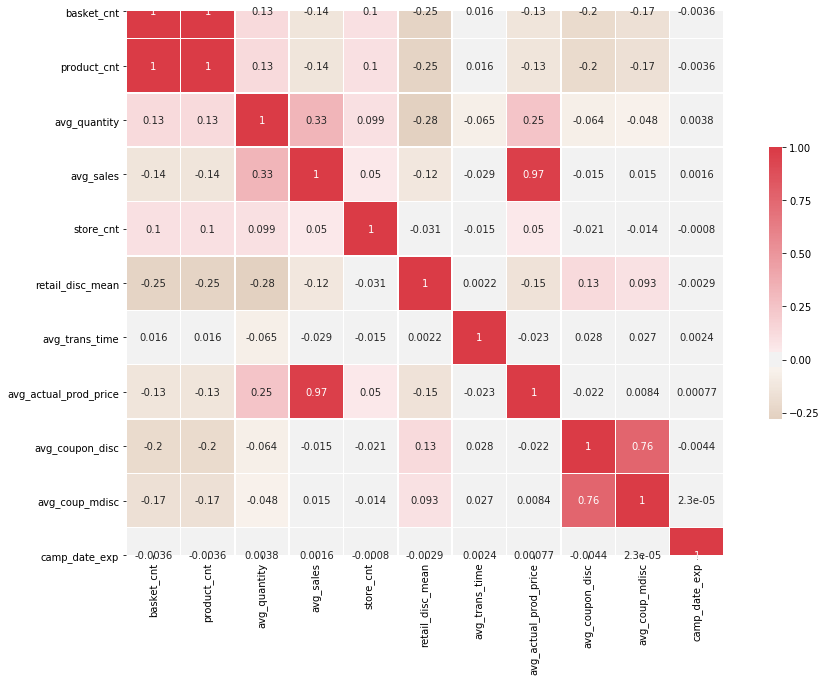

In [84]:
spearman_corrx = {}
for i in feat_select_cols:
    spearman_corrx[i] = agg3.loc[:,i]
    
spearman_df = pd.DataFrame.from_dict(spearman_corrx)


# Compute the correlation matrix
corr = spearman_df.corr(method='spearman')

# Generate a mask for the upper triangle
#mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(40, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 10-) remove one of highly correlated features

In [85]:
feat_select_cols.remove('product_cnt')
feat_select_cols.remove('avg_actual_prod_price')
feat_select_cols.remove('avg_coup_mdisc')
feat_select_cols

['basket_cnt',
 'avg_quantity',
 'avg_sales',
 'store_cnt',
 'retail_disc_mean',
 'avg_trans_time',
 'avg_coupon_disc',
 'camp_date_exp']

In [86]:
agg3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225344 entries, 0 to 225343
Data columns (total 25 columns):
household_key            225344 non-null int64
DAY                      225344 non-null int64
WEEK_NO                  225344 non-null int64
basket_cnt               225344 non-null float64
product_cnt              225344 non-null float64
avg_quantity             225344 non-null float64
avg_sales                225344 non-null float64
store_cnt                225344 non-null float64
retail_disc_mean         225344 non-null float64
avg_trans_time           225344 non-null float64
avg_actual_prod_price    225344 non-null float64
avg_coupon_disc          225344 non-null float64
avg_coup_mdisc           225344 non-null float64
most_freq_depart         225344 non-null object
most_freq_brand          225344 non-null object
most_freq_commodity      225344 non-null object
most_freq_camp           225344 non-null object
most_freq_display        225344 non-null int32
most_freq_mailer   

### 12-) check cramers correlation between target variable and categoric columns

In [87]:
def cramers_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [88]:
categoric_columns = ['most_freq_depart','most_freq_brand','most_freq_commodity','most_freq_camp']

In [89]:
for col in categoric_columns:
    confus = pd.crosstab(agg3[col], agg3['is_churned'])
    print(cramers_stat(confus),col)

is_churned
0   0.02736
1   0.07480
dtype: float64 most_freq_depart
is_churned
0   0.00576
1   0.01576
dtype: float64 most_freq_brand
is_churned
0   0.06690
1   0.18287
dtype: float64 most_freq_commodity
is_churned
0   nan
1   nan
dtype: float64 most_freq_camp


#### comment : we can use most_freq_commodity in our model

### 13-) check the distributions of continous variables regard to target variable

In [90]:
agg3.groupby('is_churned')[feat_select_cols].describe().T

is_churned                        0           1
basket_cnt       count 198746.00000 26598.00000
                 mean       8.80389     8.24212
                 std        7.52562     7.24868
                 min        1.00000     1.00000
                 25%        3.00000     3.00000
                 50%        7.00000     6.00000
                 75%       12.00000    11.45858
                 max       33.00000    33.00000
avg_quantity     count 198746.00000 26598.00000
                 mean      91.24764    84.02939
                 std      230.33633   222.24467
                 min        1.00000     1.00000
                 25%        1.00000     1.00000
                 50%        1.20000     1.20000
                 75%        1.50000     1.52941
                 max      680.64124   680.64124
avg_sales        count 198746.00000 26598.00000
                 mean       3.05853     3.05569
                 std        1.32610     1.33067
                 min        0.00000     0.00000
                 25%        2.06403     2.05669
                 50%        2.82216     2.80727
                 75%        4.04750     4.01800
                 max        7.01385     7.01111
store_cnt        count 198746.00000 26598.00000
                 mean       1.00130     1.00074
                 std        0.00670     0.00510
                 min        1.00000     1.00000
                 25%        1.00000     1.00000
                 50%        1.00000     1.00000
                 75%        1.00000     1.00000
                 max        1.03569     1.03569
retail_disc_mean count 198746.00000 26598.00000
                 mean      -0.43167    -0.43040
                 std        0.33513     0.34083
                 min       -1.48167    -1.48167
                 25%       -0.59538    -0.60000
                 50%       -0.39375    -0.39935
                 75%       -0.17000    -0.15000
                 max        0.00000     0.00000
avg_trans_time   count 198746.00000 26598.00000
                 mean    1572.12052  1574.95555
                 std      377.84607   384.29433
                 min      381.50000   382.50000
                 25%     1309.00000  1308.00000
                 50%     1613.00000  1606.00000
                 75%     1845.00000  1850.00000
                 max     2359.00000  2359.00000
avg_coupon_disc  count 198746.00000 26598.00000
                 mean      -0.00064    -0.00052
                 std        0.00249     0.00225
                 min       -0.01036    -0.01036
                 25%        0.00000     0.00000
                 50%        0.00000     0.00000
                 75%        0.00000     0.00000
                 max        0.00000     0.00000
camp_date_exp    count 198746.00000 26598.00000
                 mean       0.06036     0.05607
                 std        0.21436     0.20719
                 min        0.00000     0.00000
                 25%        0.00000     0.00000
                 50%        0.00000     0.00000
                 75%        0.00000     0.00000
                 max        0.82165     0.82165

#### comment: avg_sales, store_cnt dont make clear seperation

### remove these columns

In [91]:
feat_select_cols.remove('avg_sales')
feat_select_cols.remove('store_cnt')
feat_select_cols

['basket_cnt',
 'avg_quantity',
 'retail_disc_mean',
 'avg_trans_time',
 'avg_coupon_disc',
 'camp_date_exp']

### 14-) now get historical information

In [92]:
def rolling_avg(df, column, point, time_idx='WEEK_NO',group='household_key', name_format="{}_{}_week_average", verbose=True):
    """
    Apply rolling window calculation and **numpy.nanmean** function to the result to get the mean of the window
    args consists:
        - **column**: Column to evaluate
        - **point**: Rolling window parameter
        - **group**: Parameter to group the frame. Used in *group_by* function.
        - **name_format**: It is used to initiate the name of the new column with the *column* and *point* param
        - **verbose**: Boolean parameter to follow the function's evaluation. If yes, it prints information during.

    :param args: Arguments are -> column, point, group, name_format, verbose.
    :return: Updated data-frame
    """
    try:
        if verbose:
            print("average column: {} point: {}".format(column, point))
        name = name_format.format(column, point)
        print(name)
        result = df.groupby([group])[column].rolling(window=point).mean().values
        df[name] = result
        return df
    except Exception as ex:
        print(ex)
        raise

In [93]:
points = [2, 3, 4, 5, 6, 8, 10, 15]
for point in points:
    for col in feat_select_cols:
        rolling_avg(agg3,column=col,point=point)

average column: basket_cnt point: 2
basket_cnt_2_week_average
average column: avg_quantity point: 2
avg_quantity_2_week_average
average column: retail_disc_mean point: 2
retail_disc_mean_2_week_average
average column: avg_trans_time point: 2
avg_trans_time_2_week_average
average column: avg_coupon_disc point: 2
avg_coupon_disc_2_week_average
average column: camp_date_exp point: 2
camp_date_exp_2_week_average
average column: basket_cnt point: 3
basket_cnt_3_week_average
average column: avg_quantity point: 3
avg_quantity_3_week_average
average column: retail_disc_mean point: 3
retail_disc_mean_3_week_average
average column: avg_trans_time point: 3
avg_trans_time_3_week_average
average column: avg_coupon_disc point: 3
avg_coupon_disc_3_week_average
average column: camp_date_exp point: 3
camp_date_exp_3_week_average
average column: basket_cnt point: 4
basket_cnt_4_week_average
average column: avg_quantity point: 4
avg_quantity_4_week_average
average column: retail_disc_mean point: 4
retail

In [94]:
agg3.head()

,household_key,DAY,WEEK_NO,basket_cnt,product_cnt,avg_quantity,avg_sales,store_cnt,retail_disc_mean,avg_trans_time,avg_actual_prod_price,avg_coupon_disc,avg_coup_mdisc,most_freq_depart,most_freq_brand,most_freq_commodity,most_freq_camp,most_freq_display,most_freq_mailer,camp_date_exp,index,MAX_WEEK,MAX_DATA_WEEK,CohortIndex,is_churned,basket_cnt_2_week_average,avg_quantity_2_week_average,retail_disc_mean_2_week_average,avg_trans_time_2_week_average,avg_coupon_disc_2_week_average,camp_date_exp_2_week_average,basket_cnt_3_week_average,avg_quantity_3_week_average,retail_disc_mean_3_week_average,avg_trans_time_3_week_average,avg_coupon_disc_3_week_average,camp_date_exp_3_week_average,basket_cnt_4_week_average,avg_quantity_4_week_average,retail_disc_mean_4_week_average,avg_trans_time_4_week_average,avg_coupon_disc_4_week_average,camp_date_exp_4_week_average,basket_cnt_5_week_average,avg_quantity_5_week_average,retail_disc_mean_5_week_average,avg_trans_time_5_week_average,avg_coupon_disc_5_week_average,camp_date_exp_5_week_average,basket_cnt_6_week_average,avg_quantity_6_week_average,retail_disc_mean_6_week_average,avg_trans_time_6_week_average,avg_coupon_disc_6_week_average,camp_date_exp_6_week_average,basket_cnt_8_week_average,avg_quantity_8_week_average,retail_disc_mean_8_week_average,avg_trans_time_8_week_average,avg_coupon_disc_8_week_average,camp_date_exp_8_week_average,basket_cnt_10_week_average,avg_quantity_10_week_average,retail_disc_mean_10_week_average,avg_trans_time_10_week_average,avg_coupon_disc_10_week_average,camp_date_exp_10_week_average,basket_cnt_15_week_average,avg_quantity_15_week_average,retail_disc_mean_15_week_average,avg_trans_time_15_week_average,avg_coupon_disc_15_week_average,camp_date_exp_15_week_average
0,1,51,8,30.00000,30.00000,1.13333,2.62200,1.00000,-0.55133,1456.00000,2.58567,-0.01036,0.00000,GROCERY,National,FRUIT - SHELF STABLE,TypeA,0,0,0.00000,0,102.00000,102,94,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,1,67,10,11.00000,11.00000,1.27273,3.73636,1.00000,-0.78091,2002.00000,3.49636,0.00000,0.00000,GROCERY,National,CANDY - PACKAGED,TypeA,0,0,0.00000,0,102.00000,102,92,0,20.50000,1.20303,-0.66612,1729.00000,-0.00518,0.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,1,88,13,12.00000,12.00000,1.08333,2.24167,1.00000,-0.56000,1604.00000,2.24167,0.00000,0.00000,GROCERY,National,BAG SNACKS,TypeA,0,0,0.00000,0,102.00000,102,89,0,11.50000,1.17803,-0.67045,1803.00000,0.00000,0.00000,17.66667,1.16313,-0.63075,1687.33333,-0.00345,0.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,1,94,14,22.00000,22.00000,1.45455,2.88318,1.00000,-0.50364,1937.00000,2.72045,-0.01036,-0.00171,GROCERY,National,DELI MEATS,TypeA,0,0,0.00000,0,102.00000,102,88,0,17.00000,1.26894,-0.53182,1770.50000,-0.00518,0.00000,15.00000,1.27020,-0.61485,1847.66667,-0.00345,0.00000,18.75000,1.23598,-0.59897,1749.75000,-0.00518,0.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,1,101,15,17.00000,17.00000,1.17647,3.14412,1.00000,-0.96588,1603.00000,3.14412,0.00000,0.00000,GROCERY,National,BAKED BREAD/BUNS/ROLLS,TypeA,0,0,0.00000,0,102.00000,102,87,0,19.50000,1.31551,-0.73476,1770.00000,-0.00518,0.00000,17.00000,1.23812,-0.67651,1714.66667,-0.00345,0.00000,15.50000,1.24677,-0.70261,1786.50000,-0.00259,0.00000,18.40000,1.22408,-0.67235,1720.40000,-0.00414,0.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### check nulls again

In [95]:
agg3.isnull().sum()

household_key                           0
DAY                                     0
WEEK_NO                                 0
basket_cnt                              0
product_cnt                             0
avg_quantity                            0
avg_sales                               0
store_cnt                               0
retail_disc_mean                        0
avg_trans_time                          0
avg_actual_prod_price                   0
avg_coupon_disc                         0
avg_coup_mdisc                          0
most_freq_depart                        0
most_freq_brand                         0
most_freq_commodity                     0
most_freq_camp                          0
most_freq_display                       0
most_freq_mailer                        0
camp_date_exp                           0
index                                   0
MAX_WEEK                                0
MAX_DATA_WEEK                           0
CohortIndex                       

### 15-) replace nulls with zero

In [96]:
agg3.replace([np.inf, -np.inf], np.nan, inplace=True)
agg3.fillna(0, inplace=True)
agg3.isnull().sum()

household_key                       0
DAY                                 0
WEEK_NO                             0
basket_cnt                          0
product_cnt                         0
avg_quantity                        0
avg_sales                           0
store_cnt                           0
retail_disc_mean                    0
avg_trans_time                      0
avg_actual_prod_price               0
avg_coupon_disc                     0
avg_coup_mdisc                      0
most_freq_depart                    0
most_freq_brand                     0
most_freq_commodity                 0
most_freq_camp                      0
most_freq_display                   0
most_freq_mailer                    0
camp_date_exp                       0
index                               0
MAX_WEEK                            0
MAX_DATA_WEEK                       0
CohortIndex                         0
is_churned                          0
basket_cnt_2_week_average           0
avg_quantity

### 16-) I will not take some columns especially 45 week averages

In [97]:
cols_to_feat_select = agg3.columns.tolist()[3:]
cols_to_feat_select.remove('MAX_WEEK')
cols_to_feat_select.remove('MAX_DATA_WEEK')
cols_to_feat_select.remove('CohortIndex')
cols_to_feat_select.remove('is_churned')
cols_to_feat_select.remove('most_freq_depart')
cols_to_feat_select.remove('most_freq_brand')
cols_to_feat_select.remove('most_freq_commodity')
cols_to_feat_select.remove('most_freq_camp')
cols_to_feat_select.remove('most_freq_display')
cols_to_feat_select.remove('most_freq_mailer')
cols_to_feat_select.remove('product_cnt')
cols_to_feat_select.remove('avg_actual_prod_price')
cols_to_feat_select.remove('avg_coup_mdisc')
cols_to_feat_select.remove('avg_sales')
cols_to_feat_select.remove('store_cnt')
cols_to_feat_select.remove('index')
cols_to_feat_select

['basket_cnt',
 'avg_quantity',
 'retail_disc_mean',
 'avg_trans_time',
 'avg_coupon_disc',
 'camp_date_exp',
 'basket_cnt_2_week_average',
 'avg_quantity_2_week_average',
 'retail_disc_mean_2_week_average',
 'avg_trans_time_2_week_average',
 'avg_coupon_disc_2_week_average',
 'camp_date_exp_2_week_average',
 'basket_cnt_3_week_average',
 'avg_quantity_3_week_average',
 'retail_disc_mean_3_week_average',
 'avg_trans_time_3_week_average',
 'avg_coupon_disc_3_week_average',
 'camp_date_exp_3_week_average',
 'basket_cnt_4_week_average',
 'avg_quantity_4_week_average',
 'retail_disc_mean_4_week_average',
 'avg_trans_time_4_week_average',
 'avg_coupon_disc_4_week_average',
 'camp_date_exp_4_week_average',
 'basket_cnt_5_week_average',
 'avg_quantity_5_week_average',
 'retail_disc_mean_5_week_average',
 'avg_trans_time_5_week_average',
 'avg_coupon_disc_5_week_average',
 'camp_date_exp_5_week_average',
 'basket_cnt_6_week_average',
 'avg_quantity_6_week_average',
 'retail_disc_mean_6_week_av

### 17-) add more features

In [98]:
feat_select_cols

['basket_cnt',
 'avg_quantity',
 'retail_disc_mean',
 'avg_trans_time',
 'avg_coupon_disc',
 'camp_date_exp']

In [99]:
min_df = agg3.groupby('household_key')[feat_select_cols].min()
max_df = agg3.groupby('household_key')[feat_select_cols].max()

In [100]:
agg4 = pd.merge(agg3,min_df,how='inner',on='household_key')

In [101]:
agg4 = agg4.rename(columns={'basket_cnt_x': 'basket_cnt',
                     'avg_quantity_x' : 'avg_quantity',
                     'retail_disc_mean_x': 'retail_disc_mean',
                     'avg_trans_time_x' : 'avg_trans_time',
                     'avg_coupon_disc_x': 'avg_coupon_disc',
                     'camp_date_exp_x': 'camp_date_exp' ,
                     'basket_cnt_y' : 'basket_cnt_min',
                     'avg_quantity_y':'avg_quantity_min',
                     'retail_disc_mean_y':'retail_disc_mean_min',
                     'avg_trans_time_y':'avg_trans_time_min',
                     'avg_coupon_disc_y':'avg_coupon_disc_min',
                     'camp_date_exp_y':'camp_date_exp_min'})

In [102]:
agg4.head()

,household_key,DAY,WEEK_NO,basket_cnt,product_cnt,avg_quantity,avg_sales,store_cnt,retail_disc_mean,avg_trans_time,avg_actual_prod_price,avg_coupon_disc,avg_coup_mdisc,most_freq_depart,most_freq_brand,most_freq_commodity,most_freq_camp,most_freq_display,most_freq_mailer,camp_date_exp,index,MAX_WEEK,MAX_DATA_WEEK,CohortIndex,is_churned,basket_cnt_2_week_average,avg_quantity_2_week_average,retail_disc_mean_2_week_average,avg_trans_time_2_week_average,avg_coupon_disc_2_week_average,camp_date_exp_2_week_average,basket_cnt_3_week_average,avg_quantity_3_week_average,retail_disc_mean_3_week_average,avg_trans_time_3_week_average,avg_coupon_disc_3_week_average,camp_date_exp_3_week_average,basket_cnt_4_week_average,avg_quantity_4_week_average,retail_disc_mean_4_week_average,avg_trans_time_4_week_average,avg_coupon_disc_4_week_average,camp_date_exp_4_week_average,basket_cnt_5_week_average,avg_quantity_5_week_average,retail_disc_mean_5_week_average,avg_trans_time_5_week_average,avg_coupon_disc_5_week_average,camp_date_exp_5_week_average,basket_cnt_6_week_average,avg_quantity_6_week_average,retail_disc_mean_6_week_average,avg_trans_time_6_week_average,avg_coupon_disc_6_week_average,camp_date_exp_6_week_average,basket_cnt_8_week_average,avg_quantity_8_week_average,retail_disc_mean_8_week_average,avg_trans_time_8_week_average,avg_coupon_disc_8_week_average,camp_date_exp_8_week_average,basket_cnt_10_week_average,avg_quantity_10_week_average,retail_disc_mean_10_week_average,avg_trans_time_10_week_average,avg_coupon_disc_10_week_average,camp_date_exp_10_week_average,basket_cnt_15_week_average,avg_quantity_15_week_average,retail_disc_mean_15_week_average,avg_trans_time_15_week_average,avg_coupon_disc_15_week_average,camp_date_exp_15_week_average,basket_cnt_min,avg_quantity_min,retail_disc_mean_min,avg_trans_time_min,avg_coupon_disc_min,camp_date_exp_min
0,1,51,8,30.00000,30.00000,1.13333,2.62200,1.00000,-0.55133,1456.00000,2.58567,-0.01036,0.00000,GROCERY,National,FRUIT - SHELF STABLE,TypeA,0,0,0.00000,0,102.00000,102,94,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,-1.20800,1013.00000,-0.01036,0.00000
1,1,67,10,11.00000,11.00000,1.27273,3.73636,1.00000,-0.78091,2002.00000,3.49636,0.00000,0.00000,GROCERY,National,CANDY - PACKAGED,TypeA,0,0,0.00000,0,102.00000,102,92,0,20.50000,1.20303,-0.66612,1729.00000,-0.00518,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,-1.20800,1013.00000,-0.01036,0.00000
2,1,88,13,12.00000,12.00000,1.08333,2.24167,1.00000,-0.56000,1604.00000,2.24167,0.00000,0.00000,GROCERY,National,BAG SNACKS,TypeA,0,0,0.00000,0,102.00000,102,89,0,11.50000,1.17803,-0.67045,1803.00000,0.00000,0.00000,17.66667,1.16313,-0.63075,1687.33333,-0.00345,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,-1.20800,1013.00000,-0.01036,0.00000
3,1,94,14,22.00000,22.00000,1.45455,2.88318,1.00000,-0.50364,1937.00000,2.72045,-0.01036,-0.00171,GROCERY,National,DELI MEATS,TypeA,0,0,0.00000,0,102.00000,102,88,0,17.00000,1.26894,-0.53182,1770.50000,-0.00518,0.00000,15.00000,1.27020,-0.61485,1847.66667,-0.00345,0.00000,18.75000,1.23598,-0.59897,1

In [103]:
agg5 = pd.merge(agg4,max_df,how='inner',on='household_key')

In [104]:
agg5 = agg5.rename(columns={'basket_cnt_x': 'basket_cnt',
                     'avg_quantity_x' : 'avg_quantity',
                     'retail_disc_mean_x': 'retail_disc_mean',
                     'avg_trans_time_x' : 'avg_trans_time',
                     'avg_coupon_disc_x': 'avg_coupon_disc',
                     'camp_date_exp_x': 'camp_date_exp' ,
                     'basket_cnt_y' : 'basket_cnt_max',
                     'avg_quantity_y':'avg_quantity_max',
                     'retail_disc_mean_y':'retail_disc_mean_max',
                     'avg_trans_time_y':'avg_trans_time_max',
                     'avg_coupon_disc_y':'avg_coupon_disc_max',
                     'camp_date_exp_y':'camp_date_exp_max'})

In [105]:
agg5['max_min_basket_cnt_rate'] = agg5['basket_cnt_max'] / agg5['basket_cnt_min']
agg5['max_min_avg_quantity_rate'] = agg5['avg_quantity_max'] / agg5['avg_quantity_min']
agg5['max_min_retail_disc_mean_rate'] = agg5['retail_disc_mean_max'] / agg5['retail_disc_mean_min']
agg5['max_min_avg_trans_time_rate'] = agg5['avg_trans_time_max'] / agg5['avg_trans_time_min']
agg5['max_min_avg_coupon_disc_rate'] = agg5['avg_coupon_disc_max'] / agg5['avg_coupon_disc_min']
agg5['max_min_camp_date_exp_rate'] = agg5['camp_date_exp_max'] / agg5['camp_date_exp_min']

In [106]:
agg5.replace([np.inf, -np.inf], np.nan, inplace=True)
agg5.fillna(0, inplace=True)
agg5.isnull().sum()

household_key                       0
DAY                                 0
WEEK_NO                             0
basket_cnt                          0
product_cnt                         0
avg_quantity                        0
avg_sales                           0
store_cnt                           0
retail_disc_mean                    0
avg_trans_time                      0
avg_actual_prod_price               0
avg_coupon_disc                     0
avg_coup_mdisc                      0
most_freq_depart                    0
most_freq_brand                     0
most_freq_commodity                 0
most_freq_camp                      0
most_freq_display                   0
most_freq_mailer                    0
camp_date_exp                       0
index                               0
MAX_WEEK                            0
MAX_DATA_WEEK                       0
CohortIndex                         0
is_churned                          0
basket_cnt_2_week_average           0
avg_quantity

In [107]:
agg5.columns.tolist()

['household_key',
 'DAY',
 'WEEK_NO',
 'basket_cnt',
 'product_cnt',
 'avg_quantity',
 'avg_sales',
 'store_cnt',
 'retail_disc_mean',
 'avg_trans_time',
 'avg_actual_prod_price',
 'avg_coupon_disc',
 'avg_coup_mdisc',
 'most_freq_depart',
 'most_freq_brand',
 'most_freq_commodity',
 'most_freq_camp',
 'most_freq_display',
 'most_freq_mailer',
 'camp_date_exp',
 'index',
 'MAX_WEEK',
 'MAX_DATA_WEEK',
 'CohortIndex',
 'is_churned',
 'basket_cnt_2_week_average',
 'avg_quantity_2_week_average',
 'retail_disc_mean_2_week_average',
 'avg_trans_time_2_week_average',
 'avg_coupon_disc_2_week_average',
 'camp_date_exp_2_week_average',
 'basket_cnt_3_week_average',
 'avg_quantity_3_week_average',
 'retail_disc_mean_3_week_average',
 'avg_trans_time_3_week_average',
 'avg_coupon_disc_3_week_average',
 'camp_date_exp_3_week_average',
 'basket_cnt_4_week_average',
 'avg_quantity_4_week_average',
 'retail_disc_mean_4_week_average',
 'avg_trans_time_4_week_average',
 'avg_coupon_disc_4_week_average

### calculate new columns

In [108]:
agg5['basket_cnt_2_rate'] = agg5['basket_cnt'] / agg5['basket_cnt_2_week_average']
agg5['basket_cnt_3_rate'] = agg5['basket_cnt'] / agg5['basket_cnt_3_week_average']
agg5['basket_cnt_4_rate'] = agg5['basket_cnt'] / agg5['basket_cnt_4_week_average']
agg5['basket_cnt_5_rate'] = agg5['basket_cnt'] / agg5['basket_cnt_5_week_average']
agg5['basket_cnt_6_rate'] = agg5['basket_cnt'] / agg5['basket_cnt_6_week_average']
agg5['basket_cnt_8_rate'] = agg5['basket_cnt'] / agg5['basket_cnt_8_week_average']
agg5['basket_cnt_10_rate'] = agg5['basket_cnt'] / agg5['basket_cnt_10_week_average']
agg5['basket_cnt_15_rate'] = agg5['basket_cnt'] / agg5['basket_cnt_15_week_average']


agg5['avg_quantity_2_rate'] = agg5['avg_quantity'] / agg5['avg_quantity_2_week_average']
agg5['avg_quantity_3_rate'] = agg5['avg_quantity'] / agg5['avg_quantity_3_week_average']
agg5['avg_quantity_4_rate'] = agg5['avg_quantity'] / agg5['avg_quantity_4_week_average']
agg5['avg_quantity_5_rate'] = agg5['avg_quantity'] / agg5['avg_quantity_5_week_average']
agg5['avg_quantity_6_rate'] = agg5['avg_quantity'] / agg5['avg_quantity_6_week_average']
agg5['avg_quantity_8_rate'] = agg5['avg_quantity'] / agg5['avg_quantity_8_week_average']
agg5['avg_quantity_10_rate'] = agg5['avg_quantity'] / agg5['avg_quantity_10_week_average']
agg5['avg_quantity_15_rate'] = agg5['avg_quantity'] / agg5['avg_quantity_15_week_average']


agg5['retail_disc_mean_2_rate'] = agg5['retail_disc_mean'] / agg5['retail_disc_mean_2_week_average']
agg5['retail_disc_mean_3_rate'] = agg5['retail_disc_mean'] / agg5['retail_disc_mean_3_week_average']
agg5['retail_disc_mean_4_rate'] = agg5['retail_disc_mean'] / agg5['retail_disc_mean_4_week_average']
agg5['retail_disc_mean_5_rate'] = agg5['retail_disc_mean'] / agg5['retail_disc_mean_5_week_average']
agg5['retail_disc_mean_6_rate'] = agg5['retail_disc_mean'] / agg5['retail_disc_mean_6_week_average']
agg5['retail_disc_mean_8_rate'] = agg5['retail_disc_mean'] / agg5['retail_disc_mean_8_week_average']
agg5['retail_disc_mean_10_rate'] = agg5['retail_disc_mean'] / agg5['retail_disc_mean_10_week_average']
agg5['retail_disc_mean_15_rate'] = agg5['retail_disc_mean'] / agg5['retail_disc_mean_15_week_average']


agg5['avg_trans_time_2_rate'] = agg5['avg_trans_time'] / agg5['avg_trans_time_2_week_average']
agg5['avg_trans_time_3_rate'] = agg5['avg_trans_time'] / agg5['avg_trans_time_3_week_average']
agg5['avg_trans_time_4_rate'] = agg5['avg_trans_time'] / agg5['avg_trans_time_4_week_average']
agg5['avg_trans_time_5_rate'] = agg5['avg_trans_time'] / agg5['avg_trans_time_5_week_average']
agg5['avg_trans_time_6_rate'] = agg5['avg_trans_time'] / agg5['avg_trans_time_6_week_average']
agg5['avg_trans_time_8_rate'] = agg5['avg_trans_time'] / agg5['avg_trans_time_8_week_average']
agg5['avg_trans_time_10_rate'] = agg5['avg_trans_time'] / agg5['avg_trans_time_10_week_average']
agg5['avg_trans_time_15_rate'] = agg5['avg_trans_time'] / agg5['avg_trans_time_15_week_average']


agg5['avg_coupon_disc_2_rate'] = agg5['avg_coupon_disc'] / agg5['avg_coupon_disc_2_week_average']
agg5['avg_coupon_disc_3_rate'] = agg5['avg_coupon_disc'] / agg5['avg_coupon_disc_3_week_average']
agg5['avg_coupon_disc_4_rate'] = agg5['avg_coupon_disc'] / agg5['avg_coupon_disc_4_week_average']
agg5['avg_coupon_disc_5_rate'] = agg5['avg_coupon_disc'] / agg5['avg_coupon_disc_5_week_average']
agg5['avg_coupon_disc_6_rate'] = agg5['avg_coupon_disc'] / agg5['avg_coupon_disc_6_week_average']
agg5['avg_coupon_disc_8_rate'] = agg5['avg_coupon_disc'] / agg5['avg_coupon_disc_8_week_average']
agg5['avg_coupon_disc_10_rate'] = agg5['avg_coupon_disc'] / agg5['avg_coupon_disc_10_week_average']
agg5['avg_coupon_disc_15_rate'] = agg5['avg_coupon_disc'] / agg5['avg_coupon_disc_15_week_average']



agg5['camp_date_exp_2_rate'] = agg5['camp_date_exp'] / agg5['camp_date_exp_2_week_average']
agg5['camp_date_exp_3_rate'] = agg5['camp_date_exp'] / agg5['camp_date_exp_3_week_average']
agg5['camp_date_exp_4_rate'] = agg5['camp_date_exp'] / agg5['camp_date_exp_4_week_average']
agg5['camp_date_exp_5_rate'] = agg5['camp_date_exp'] / agg5['camp_date_exp_5_week_average']
agg5['camp_date_exp_6_rate'] = agg5['camp_date_exp'] / agg5['camp_date_exp_6_week_average']
agg5['camp_date_exp_8_rate'] = agg5['camp_date_exp'] / agg5['camp_date_exp_8_week_average']
agg5['camp_date_exp_10_rate'] = agg5['camp_date_exp'] / agg5['camp_date_exp_10_week_average']
agg5['camp_date_exp_15_rate'] = agg5['camp_date_exp'] / agg5['camp_date_exp_15_week_average']

In [109]:
agg5.replace([np.inf, -np.inf], np.nan, inplace=True)
agg5.fillna(0, inplace=True)
agg5.isnull().sum()

household_key                       0
DAY                                 0
WEEK_NO                             0
basket_cnt                          0
product_cnt                         0
avg_quantity                        0
avg_sales                           0
store_cnt                           0
retail_disc_mean                    0
avg_trans_time                      0
avg_actual_prod_price               0
avg_coupon_disc                     0
avg_coup_mdisc                      0
most_freq_depart                    0
most_freq_brand                     0
most_freq_commodity                 0
most_freq_camp                      0
most_freq_display                   0
most_freq_mailer                    0
camp_date_exp                       0
index                               0
MAX_WEEK                            0
MAX_DATA_WEEK                       0
CohortIndex                         0
is_churned                          0
basket_cnt_2_week_average           0
avg_quantity

In [110]:
agg5.head()

,household_key,DAY,WEEK_NO,basket_cnt,product_cnt,avg_quantity,avg_sales,store_cnt,retail_disc_mean,avg_trans_time,avg_actual_prod_price,avg_coupon_disc,avg_coup_mdisc,most_freq_depart,most_freq_brand,most_freq_commodity,most_freq_camp,most_freq_display,most_freq_mailer,camp_date_exp,index,MAX_WEEK,MAX_DATA_WEEK,CohortIndex,is_churned,basket_cnt_2_week_average,avg_quantity_2_week_average,retail_disc_mean_2_week_average,avg_trans_time_2_week_average,avg_coupon_disc_2_week_average,camp_date_exp_2_week_average,basket_cnt_3_week_average,avg_quantity_3_week_average,retail_disc_mean_3_week_average,avg_trans_time_3_week_average,avg_coupon_disc_3_week_average,camp_date_exp_3_week_average,basket_cnt_4_week_average,avg_quantity_4_week_average,retail_disc_mean_4_week_average,avg_trans_time_4_week_average,avg_coupon_disc_4_week_average,camp_date_exp_4_week_average,basket_cnt_5_week_average,avg_quantity_5_week_average,retail_disc_mean_5_week_average,avg_trans_time_5_week_average,avg_coupon_disc_5_week_average,camp_date_exp_5_week_average,basket_cnt_6_week_average,avg_quantity_6_week_average,retail_disc_mean_6_week_average,avg_trans_time_6_week_average,avg_coupon_disc_6_week_average,camp_date_exp_6_week_average,basket_cnt_8_week_average,avg_quantity_8_week_average,retail_disc_mean_8_week_average,avg_trans_time_8_week_average,avg_coupon_disc_8_week_average,camp_date_exp_8_week_average,basket_cnt_10_week_average,avg_quantity_10_week_average,retail_disc_mean_10_week_average,avg_trans_time_10_week_average,avg_coupon_disc_10_week_average,camp_date_exp_10_week_average,basket_cnt_15_week_average,avg_quantity_15_week_average,retail_disc_mean_15_week_average,avg_trans_time_15_week_average,avg_coupon_disc_15_week_average,camp_date_exp_15_week_average,basket_cnt_min,avg_quantity_min,retail_disc_mean_min,avg_trans_time_min,avg_coupon_disc_min,camp_date_exp_min,basket_cnt_max,avg_quantity_max,retail_disc_mean_max,avg_trans_time_max,avg_coupon_disc_max,camp_date_exp_max,max_min_basket_cnt_rate,max_min_avg_quantity_rate,max_min_retail_disc_mean_rate,max_min_avg_trans_time_rate,max_min_avg_coupon_disc_rate,max_min_camp_date_exp_rate,basket_cnt_2_rate,basket_cnt_3_rate,basket_cnt_4_rate,basket_cnt_5_rate,basket_cnt_6_rate,basket_cnt_8_rate,basket_cnt_10_rate,basket_cnt_15_rate,avg_quantity_2_rate,avg_quantity_3_rate,avg_quantity_4_rate,avg_quantity_5_rate,avg_quantity_6_rate,avg_quantity_8_rate,avg_quantity_10_rate,avg_quantity_15_rate,retail_disc_mean_2_rate,retail_disc_mean_3_rate,retail_disc_mean_4_rate,retail_disc_mean_5_rate,retail_disc_mean_6_rate,retail_disc_mean_8_rate,retail_disc_mean_10_rate,retail_disc_mean_15_rate,avg_trans_time_2_rate,avg_trans_time_3_rate,avg_trans_time_4_rate,avg_trans_time_5_rate,avg_trans_time_6_rate,avg_trans_time_8_rate,avg_trans_time_10_rate,avg_trans_time_15_rate,avg_coupon_disc_2_rate,avg_coupon_disc_3_rate,avg_coupon_disc_4_rate,avg_coupon_disc_5_rate,avg_coupon_disc_6_rate,avg_coupon_disc_8_rate,avg_coupon_disc_10_rate,avg_coupon_disc_15_rate,camp_date_exp_2_rate,camp_date_exp_3_rate,camp_date_exp_4_rate,camp_date_exp_5_rate,camp_date_exp_6_rate,camp_date_exp_8_rate,camp_date_exp_10_rate,camp_date_exp_15_rate
0,1,51,8,30.00000,30.00000,1.13333,2.62200,1.00000,-0.55133,1456.00000,2.58567,-0.01036,0.00000,GROCERY,National,FRUIT - SHELF STABLE,TypeA,0,0,0.00000,0,102.00000,102,94,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,-1.20800,1013.00000,-0.01036,0.00000,33.00000,2.00000,0.00000,2003.00000,0.00000,0.82165,33.00000,2.00000,-0.00000,1.97730,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000

In [114]:
cols_to_feat_select2 = agg5.columns.tolist()[3:]
cols_to_feat_select2.remove('MAX_WEEK')
cols_to_feat_select2.remove('MAX_DATA_WEEK')
cols_to_feat_select2.remove('CohortIndex')
cols_to_feat_select2.remove('is_churned')
cols_to_feat_select2.remove('most_freq_depart')
cols_to_feat_select2.remove('most_freq_brand')
cols_to_feat_select2.remove('most_freq_commodity')
cols_to_feat_select2.remove('most_freq_camp')
cols_to_feat_select2.remove('most_freq_display')
cols_to_feat_select2.remove('most_freq_mailer')
cols_to_feat_select2.remove('product_cnt')
cols_to_feat_select2.remove('avg_actual_prod_price')
cols_to_feat_select2.remove('avg_coup_mdisc')
cols_to_feat_select2.remove('avg_sales')
cols_to_feat_select2.remove('store_cnt')
cols_to_feat_select2.remove('index')
cols_to_feat_select2

['basket_cnt',
 'avg_quantity',
 'retail_disc_mean',
 'avg_trans_time',
 'avg_coupon_disc',
 'camp_date_exp',
 'basket_cnt_2_week_average',
 'avg_quantity_2_week_average',
 'retail_disc_mean_2_week_average',
 'avg_trans_time_2_week_average',
 'avg_coupon_disc_2_week_average',
 'camp_date_exp_2_week_average',
 'basket_cnt_3_week_average',
 'avg_quantity_3_week_average',
 'retail_disc_mean_3_week_average',
 'avg_trans_time_3_week_average',
 'avg_coupon_disc_3_week_average',
 'camp_date_exp_3_week_average',
 'basket_cnt_4_week_average',
 'avg_quantity_4_week_average',
 'retail_disc_mean_4_week_average',
 'avg_trans_time_4_week_average',
 'avg_coupon_disc_4_week_average',
 'camp_date_exp_4_week_average',
 'basket_cnt_5_week_average',
 'avg_quantity_5_week_average',
 'retail_disc_mean_5_week_average',
 'avg_trans_time_5_week_average',
 'avg_coupon_disc_5_week_average',
 'camp_date_exp_5_week_average',
 'basket_cnt_6_week_average',
 'avg_quantity_6_week_average',
 'retail_disc_mean_6_week_av

### 17-) apply boruta feature selection algorithm to get best features

In [115]:
# load X and y
# NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
X = agg5[cols_to_feat_select2].values
y = agg5['is_churned']
y = y.ravel()
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators=50, verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X, y)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	120
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	120
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	120
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	120
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	120
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	120
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	120
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	57
Tentative: 	48
Rejected: 	15
Iteration: 	9 / 100
Confirmed: 	57
Tentative: 	48
Rejected: 	15
Iteration: 	10 / 100
Confirmed: 	57
Tentative: 	48
Rejected: 	15
Iteration: 	11 / 100
Confirmed: 	57
Tentative: 	48
Rejected: 	15
Iteration: 	12 / 100
Confirmed: 	64
Tentative: 	41
Rejected: 	15
Iteration: 	13 / 100
Confirmed: 	64
Tentative: 	41
Rejected: 	15
Iteration: 	14 / 100
Confirmed: 	64
Tentative: 	41
Rejected: 	15
Iteration: 	15 / 100
Confirmed: 	64
Tentative: 	41
Rejected: 	15
Iteration: 	16 / 100
Confirmed: 	66
Tenta

In [116]:
final_features = list()
indexes = np.where(feat_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(cols_to_feat_select2[x])
print(final_features)

['basket_cnt', 'retail_disc_mean', 'avg_trans_time', 'basket_cnt_2_week_average', 'avg_quantity_2_week_average', 'avg_trans_time_2_week_average', 'basket_cnt_3_week_average', 'avg_quantity_3_week_average', 'retail_disc_mean_3_week_average', 'avg_trans_time_3_week_average', 'camp_date_exp_3_week_average', 'basket_cnt_4_week_average', 'avg_quantity_4_week_average', 'retail_disc_mean_4_week_average', 'avg_trans_time_4_week_average', 'avg_coupon_disc_4_week_average', 'camp_date_exp_4_week_average', 'basket_cnt_5_week_average', 'avg_quantity_5_week_average', 'retail_disc_mean_5_week_average', 'avg_trans_time_5_week_average', 'avg_coupon_disc_5_week_average', 'camp_date_exp_5_week_average', 'basket_cnt_6_week_average', 'avg_quantity_6_week_average', 'retail_disc_mean_6_week_average', 'avg_trans_time_6_week_average', 'avg_coupon_disc_6_week_average', 'camp_date_exp_6_week_average', 'basket_cnt_8_week_average', 'avg_quantity_8_week_average', 'retail_disc_mean_8_week_average', 'avg_trans_time_8

#### comment : it looks like boruta algorithm didnt give desired result

### 18-) apply logistic regression feature selection to get most important 10 features

### I will run SMOTE algorithm to make data balanced and then run feature selection

In [119]:
from sklearn.model_selection import train_test_split
os = SMOTE(random_state=0)
X = agg5[cols_to_feat_select2].values
y = agg5['is_churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = cols_to_feat_select2
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['is_churned'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))

length of oversampled data is  278282


### 19-) apply logistic feature selection

In [120]:
logreg = LogisticRegression()
rfe = RFE(logreg, 10)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
  True False False False False  True False False False  True False False
 False False False False  True False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False  True  True False False  True False False]
[ 13  97 107  86  98  53  27  33  94  58 104  56  26  52  89  83 102  62
  21  40  84  77 100  79  17  39  78  46  92  87  28  67  82  74  95  91
  29  63  76  81 101  71  15  55  70  85 103  50   6  59  75  35 106  41
  51  42   1  19  64 111   1  65  60  32 110   1  

C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 20-) get the important features

In [121]:
final_features2 = list()
indexes = np.where(rfe.support_ == True)
for x in np.nditer(indexes):
    final_features2.append(cols_to_feat_select2[x])
print(final_features2)

['retail_disc_mean_min', 'basket_cnt_max', 'camp_date_exp_max', 'max_min_avg_trans_time_rate', 'basket_cnt_6_rate', 'basket_cnt_15_rate', 'avg_trans_time_15_rate', 'camp_date_exp_3_rate', 'camp_date_exp_4_rate', 'camp_date_exp_8_rate']


### 21-) apply model to selected features in whole data

In [122]:
import statsmodels.api as sm
X=os_data_X[final_features2].values
y=os_data_y['is_churned'].values
logit_model=sm.Logit(y.astype('float'),X.astype('float'))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.670452
         Iterations 5
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.033      
Dependent Variable: y                AIC:              373169.2982
Date:               2020-02-04 00:44 BIC:              373274.6621
No. Observations:   278282           Log-Likelihood:   -1.8657e+05
Df Model:           9                LL-Null:          -1.9289e+05
Df Residuals:       278272           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
x1        -1.2930     0.0193   -66.9222   0.0000   -1.3309   -1.2552
x2        -0.0141     0.0007   -20.0481   0.0

### 22-) fit logistic regression

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\Hincal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### 23-) make predictions and check result

In [124]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.68


### 24-) check true / false rates from confusion matrix

In [125]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[32311  9576]
 [17186 24412]]


### Thanks Hincal Topcuoglu